# Team Members:
- Amirhossein Mobayen
- Mohamed amine Filali
- Nikita Chistyakov
- Rym Mehdi
- Skander Ben brik

## Topic:
Favorite Pet prediction and modelling

# Objective:

We set out to check if an image/picture contains our favorite pet or not based on the “dogs vs cats” dataset. The important aspect for our team is to define our classification strategy. We compare a custom-made model with a pre-trained model to decide if the pet prediction is accurate since it would be interesting to notice what the model returns because it is otherwise a simple task for most humans.

## Libraries

In [1]:
import matplotlib.pyplot as plt
# Basic packages
import numpy as np
import pandas as pd
import os

# Tensorflow
import tensorflow as tf
# Sklearn
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps

2023-07-10 19:37:31.768936: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 19:37:31.913807: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 19:37:32.724844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Discovery of data:

The training archive contains 25,000 images of dogs and cats. We trained our algorithm on 16 images and predicted binary labels for test1.zip (1 = dog, 0 = cat).

https://www.kaggle.com/competitions/dogs-vs-cats/data

# Prepare Dataset
In this Data set we have to folder that cats and dogs are seperated from each other. so we read images then unifies them into grayscale pictures with size 64*64 inorder to be able save them on pandas data frame for model training.

In [2]:
# Set the desired width and height for resized images
width = 64
height = 64

# Initialize a list to store the processed image data
image_data = []

# Define the directories for cats and dogs
cats_directory = './data/cats'
dogs_directory = './data/dogs'

# Create a list of directories
directories = [cats_directory, dogs_directory]

# Iterate over the directories
for directory in directories:
    # Iterate over the files in the directory
    for filename in os.listdir(directory):
        # Check if the file has a valid image extension
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            # Open the image and convert it to grayscale
            img_gray_scale = ImageOps.grayscale(Image.open(os.path.join(directory, filename)))

            # Resize the image to the desired width and height
            img_resized = img_gray_scale.resize((width, height), Image.Resampling.LANCZOS)

            # Convert the image data to a DataFrame
            img_data = pd.DataFrame(np.array(img_resized).reshape(-1)).T

            # Add a column to indicate whether the image is a cat or a dog
            img_data['is_cat'] = 1 if directory == cats_directory else 0

            # Append the image data DataFrame to the list
            image_data.append(img_data)

# Concatenate all the image data DataFrames into a single DataFrame
all_image = pd.concat(image_data)

# Reset the index of the DataFrame
all_image.reset_index(drop=True, inplace=True)


# Validate Dataset whether it is read correctly or not

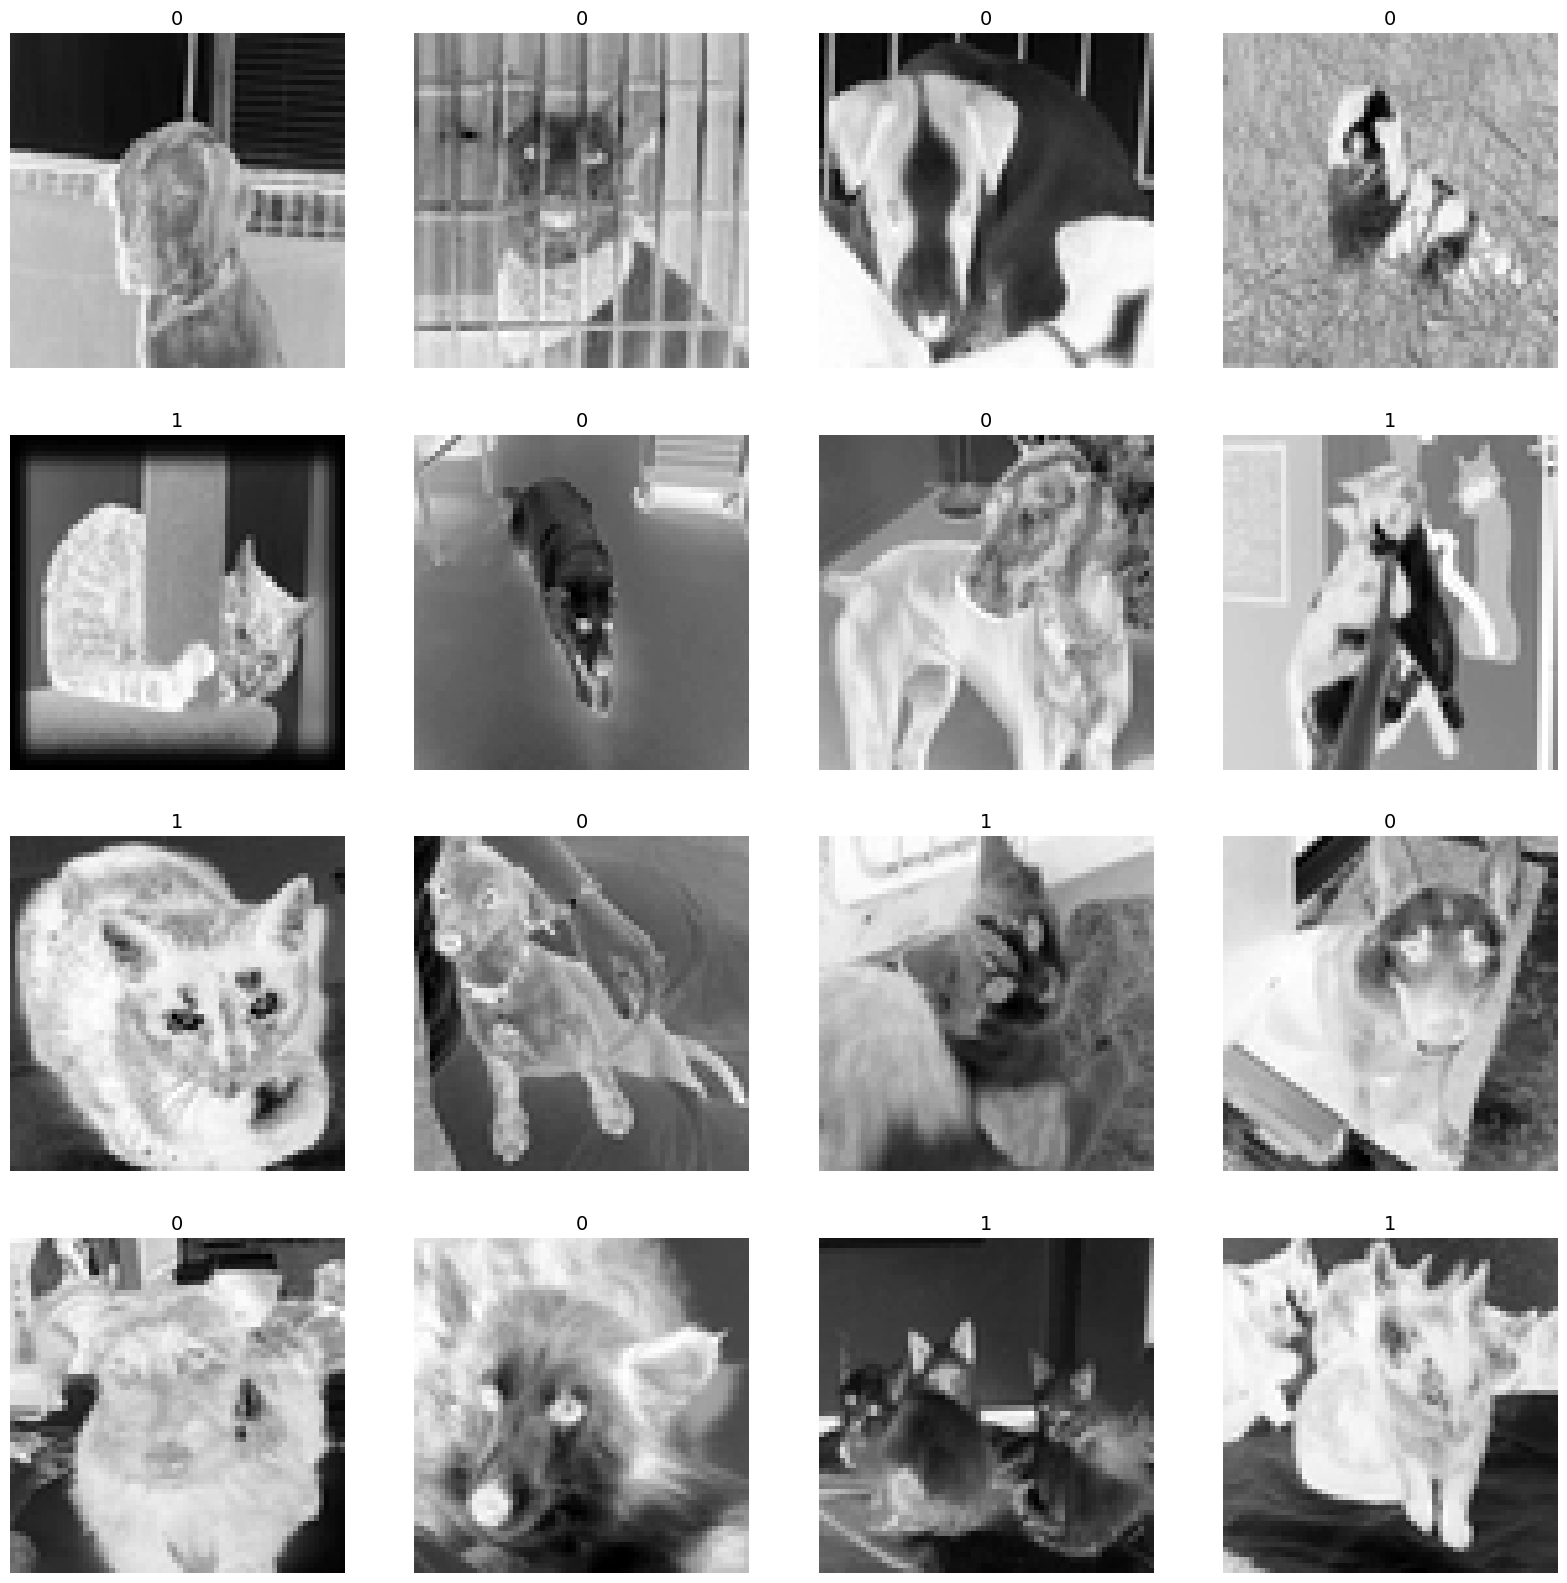

In [3]:
# Validate input!
# Create a 4x4 grid of subplots with a specified figure size
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

# Sample 16 random images from the `all_image` DataFrame
sample = all_image.sample(n=16)

# Extract the image data as a NumPy array and convert it to int64
imgs = sample.iloc[:, :-1].to_numpy().astype(np.int64)

# Extract the labels from the DataFrame as a NumPy array
labels = sample.iloc[:, -1].to_numpy()

# Iterate over the sampled images and corresponding labels, along with the subplots
for img, label, ax in zip(imgs, labels, axs.flatten()):
    # Reshape and display the image in grayscale using the 'binary' colormap
    ax.imshow(img.reshape(width, height), cmap='binary')

    # Set the title of the subplot as the label
    ax.set_title(label, fontsize=14)

    # Turn off the axis labels for cleaner visualization
    ax.axis('off')

# Display the plot
plt.show()


# Define Features and Lable

In [4]:
# Create a copy of the all_image DataFrame
X = all_image.copy()

# Extract the 'is_cat' column from X and assign it to y
y = X.pop('is_cat')


## Separate X,y into Train, Valid, and test Datasets

In [5]:
# Split the data into training and testing sets
# Stratify the split based on the 'y' labels to maintain class distribution
# Use a test size of 30% and a random state of 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Further split the training data into training and validation sets
# Stratify the split based on the 'y_train' labels to maintain class distribution
# Use a validation size of 10% of the original dataset size (X_train)
# Calculate the test size as 0.1 / (1 - 0.3) to maintain the original dataset ratio
# Use a random state of 42 for reproducibility
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1 / (1 - 0.3), random_state=42)



Data range for each pixel is from 0 to 255. So we make normalize it between 0 and 1
Convert Dataset to numpy for faster processing

In [6]:
# Normalize the pixel values of X_train, X_val, and X_test by dividing by 255
X_train /= 255
X_val /= 255
X_test /= 255

# Reshape X_train, X_val, and X_test to have the desired dimensions for input to a convolutional neural network (CNN)
# The -1 in the reshape denotes that the size of that dimension should be automatically inferred based on the other dimensions
# The dimensions are reshaped to (number of samples, width, height, channels) where channels is set to 1 for grayscale images
X_train = X_train.to_numpy().reshape(-1, width, height, 1)
X_val = X_val.to_numpy().reshape(-1, width, height, 1)
X_test = X_test.to_numpy().reshape(-1, width, height, 1)


# Model Training

In [7]:
# Clear any previous TensorFlow session
tf.keras.backend.clear_session()

# Define the CNN model architecture using the Sequential API
model_cnn = tf.keras.Sequential([
    tf.keras.Input(shape=(width, height, 1)),  # Define the input shape
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),  # Convolutional layer with 64 filters and 3x3 kernel size
    tf.keras.layers.MaxPooling2D(2),  # Max pooling layer with 2x2 pool size
    tf.keras.layers.Flatten(),  # Flatten the 2D feature maps to a 1D vector
    tf.keras.layers.Dense(1, activation='sigmoid'),  # Dense layer with 1 neuron and sigmoid activation for binary classification
])

# Print a summary of the model architecture
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 1)                 61505     
                                                                 
Total params: 62,145
Trainable params: 62,145
Non-trainable params: 0
_________________________________________________________________


2023-06-28 09:54:27.200889: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
# Define the early stopping callback to monitor validation loss and restore the best weights
early = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Set the batch size and number of epochs for training
batch_size = 64
epochs = 20

# Compile the model with Adam optimizer, binary crossentropy loss, and accuracy metric
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

# Train the model on the training data and validate on the validation data
# Use the early stopping callback to stop training if validation loss does not improve for 5 consecutive epochs
history = model_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
                        callbacks=[early])

# Evaluate the trained model on the test data
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test)

Epoch 1/20
235/235 [==============================] - 32s 132ms/step - loss: 0.6453 - accuracy: 0.6297 - val_loss: 0.6057 - val_accuracy: 0.6713
Epoch 2/20
235/235 [==============================] - 27s 115ms/step - loss: 0.5648 - accuracy: 0.7162 - val_loss: 0.5973 - val_accuracy: 0.6925
Epoch 3/20
235/235 [==============================] - 24s 102ms/step - loss: 0.5262 - accuracy: 0.7442 - val_loss: 0.5597 - val_accuracy: 0.7189
Epoch 4/20
235/235 [==============================] - 23s 98ms/step - loss: 0.4972 - accuracy: 0.7651 - val_loss: 0.5697 - val_accuracy: 0.7093
Epoch 5/20
235/235 [==============================] - 25s 107ms/step - loss: 0.4759 - accuracy: 0.7751 - val_loss: 0.5507 - val_accuracy: 0.7317
Epoch 6/20
235/235 [==============================] - 24s 103ms/step - loss: 0.4579 - accuracy: 0.7888 - val_loss: 0.5487 - val_accuracy: 0.7293
Epoch 7/20
235/235 [==============================] - 25s 108ms/step - loss: 0.4401 - accuracy: 0.8001 - val_loss: 0.5669 - val_acc

[0.5365529656410217, 0.7402666807174683]

In [9]:
# Save Model
model_cnn.save('./model/cats_dogs.model')

INFO:tensorflow:Assets written to: ./model/cats_dogs.model/assets


INFO:tensorflow:Assets written to: ./model/cats_dogs.model/assets


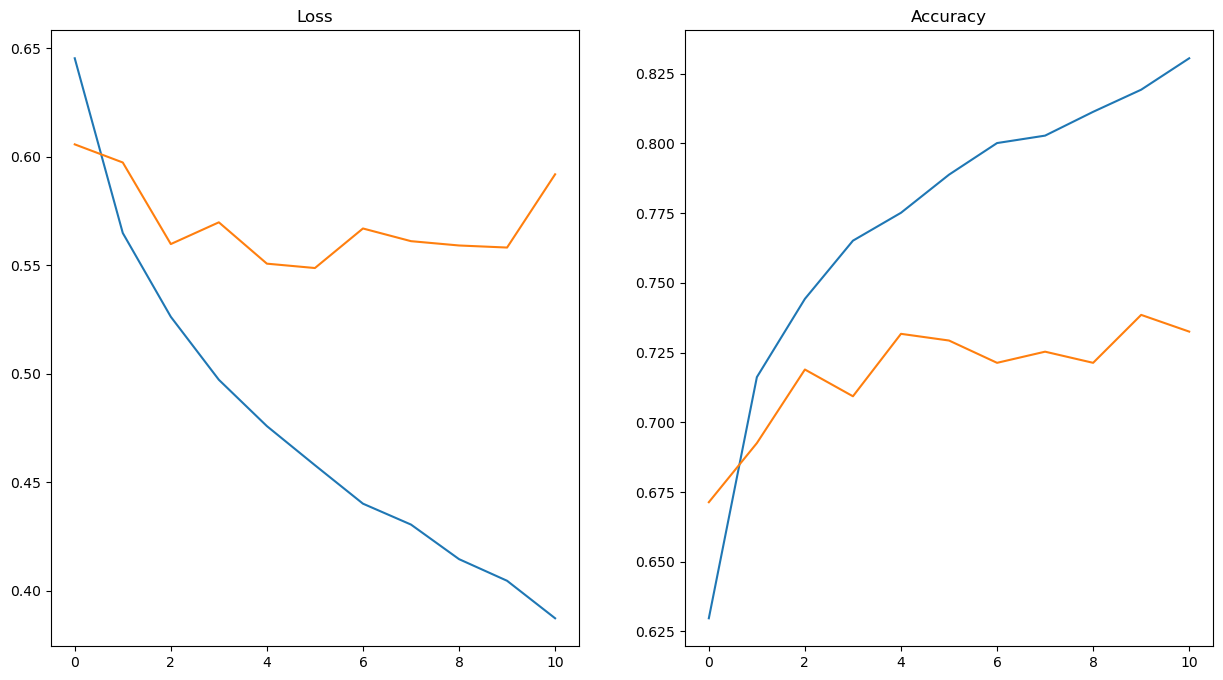

In [10]:
# Visualize the accuracy of the model

fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val loss')
axs[0].set_title('Loss')
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='val accuracy')
axs[1].set_title('Accuracy')

plt.show()

## Check With Images is it working or No

In [20]:
# test file
is_cat = './data/test1/5.jpg'

# read file and convert it to standard model
img_gray_scale = ImageOps.grayscale(Image.open(is_cat))
img_resized = img_gray_scale.resize((width, height), Image.Resampling.LANCZOS)
img_data = pd.DataFrame(np.array(img_resized).reshape(-1)).T
img_data /= 255
test = img_data.to_numpy().reshape(-1, width, height, 1)

# predict the feature
y_predict = model_cnn.predict(test)

# show the result
print('Cat' if y_predict >0.5 else 'Dog')

1/1 [==============================] - 0s 33ms/step


array([[0.95859045]], dtype=float32)

If the Answer is Above 0.5 the animal in the image cat else it is dog. so it predicted correctly

In [21]:
# test file
is_dog = './data/test1/1.jpg'

# read file and convert it to standard model
img_gray_scale = ImageOps.grayscale(Image.open(is_dog))
img_resized = img_gray_scale.resize((width, height), Image.Resampling.LANCZOS)
img_data = pd.DataFrame(np.array(img_resized).reshape(-1)).T
img_data /= 255
test = img_data.to_numpy().reshape(-1, width, height, 1)

# predict the feature
y_predict = model_cnn.predict(test)

# show the result
print('Cat' if y_predict >0.5 else 'Dog')

1/1 [==============================] - 0s 16ms/step


array([[0.37330985]], dtype=float32)

If the Answer is Above 0.5 the animal in the image cat else it is dog. so it predicted correctly

# Conclusion:

This dataset has been used as a popular benchmark for image classification, allowing for comparisons across different methods. After carefully designing architectures, and appropriate training strategies with optimization techniques, we have achieved high accuracy rates on accurately predicting a picture of a Dog vs. Cat. We are happy to say that more than 7 out 10 times our model can accurately predict our favorite pet, drastically reducing manual work that we would have otherwise needed to labour, as well as scaling the ability for classifying larger datasets.  



# Pretrain DataSet

In [2]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Load the pre-trained model
model_pretrained = tf.keras.applications.MobileNetV2(weights='imagenet')

# Load the image
image_path = './data/test1/1.jpg'
image = Image.open(image_path)

# Resize the image
image = image.resize((224, 224))

# Convert image to array
image_array = np.array(image)

# Preprocess the image
preprocessed_image = tf.keras.applications.mobilenet_v2.preprocess_input(image_array)

# Reshape the image
reshaped_image = np.expand_dims(preprocessed_image, axis=0)

# Perform object detection
predictions = model_pretrained.predict(reshaped_image)

# Get the class labels
class_labels = tf.keras.applications.mobilenet_v2.decode_predictions(predictions, top=5)[0]

# Display the predictions
for label in class_labels:
    print(f"{label[1]}: {label[2] * 100:.2f}%")


2023-07-10 19:37:58.755382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-10 19:37:58.856566: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


35363/35363 [==============================] - 0s 0us/step
Cardigan: 28.85%
kelpie: 21.00%
Border_collie: 8.81%
basenji: 5.62%
collie: 3.17%


It Predicted Correctly the animal in the picture is Dog

In [3]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Load the pre-trained model
model_pretrained = tf.keras.applications.MobileNetV2(weights='imagenet')

# Load the image
image_path = './data/test1/5.jpg'
image = Image.open(image_path)

# Resize the image
image = image.resize((224, 224))

# Convert image to array
image_array = np.array(image)

# Preprocess the image
preprocessed_image = tf.keras.applications.mobilenet_v2.preprocess_input(image_array)

# Reshape the image
reshaped_image = np.expand_dims(preprocessed_image, axis=0)

# Perform object detection
predictions = model_pretrained.predict(reshaped_image)

# Get the class labels
class_labels = tf.keras.applications.mobilenet_v2.decode_predictions(predictions, top=5)[0]

# Display the predictions
for label in class_labels:
    print(f"{label[1]}: {label[2] * 100:.2f}%")


1/1 [==============================] - 0s 388ms/step
Egyptian_cat: 19.08%
Siamese_cat: 11.99%
tiger_cat: 3.79%
tabby: 3.09%
lynx: 1.80%


It Predicted Correctly the animal in the picture is Cat

We can See That Pretrained Data has better detection system (Because of detecting the type of animal also)